In [562]:
import pandas as pd
import numpy as np 
import pyspark
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statistics import stdev
from pyspark.sql import SparkSession
from pyspark.sql.functions import round
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn import linear_model

%matplotlib inline

In [563]:
spark = SparkSession.builder.appName("Regression").getOrCreate() 
spark

In [564]:
lunch_df = spark.read.csv("StudentsPerformance.csv", header=True, inferSchema=True)
lunch_df.show()

+------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+
|gender|race/ethnicity|parental level of education|       lunch|test preparation course|math score|reading score|writing score|
+------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+
|female|       group B|          bachelor's degree|    standard|                   none|        72|           72|           74|
|female|       group C|               some college|    standard|              completed|        69|           90|           88|
|female|       group B|            master's degree|    standard|                   none|        90|           95|           93|
|  male|       group A|         associate's degree|free/reduced|                   none|        47|           57|           44|
|  male|       group C|               some college|    standard|                   none|        76|     

In [565]:
lunch_df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- race/ethnicity: string (nullable = true)
 |-- parental level of education: string (nullable = true)
 |-- lunch: string (nullable = true)
 |-- test preparation course: string (nullable = true)
 |-- math score: integer (nullable = true)
 |-- reading score: integer (nullable = true)
 |-- writing score: integer (nullable = true)



In [566]:
lunch_df = lunch_df.withColumnRenamed("test preparation course", "test prep")
lunch_df = lunch_df.withColumnRenamed("parental level of education", "parent education")
lunch_df = lunch_df.withColumn("Average Score", 
                               round((lunch_df["math score"]+lunch_df["writing score"]+lunch_df["reading score"])/3, 1))
lunch_df = lunch_df.na.drop(how="all")
lunch_df.show()

+------+--------------+------------------+------------+---------+----------+-------------+-------------+-------------+
|gender|race/ethnicity|  parent education|       lunch|test prep|math score|reading score|writing score|Average Score|
+------+--------------+------------------+------------+---------+----------+-------------+-------------+-------------+
|female|       group B| bachelor's degree|    standard|     none|        72|           72|           74|         72.7|
|female|       group C|      some college|    standard|completed|        69|           90|           88|         82.3|
|female|       group B|   master's degree|    standard|     none|        90|           95|           93|         92.7|
|  male|       group A|associate's degree|free/reduced|     none|        47|           57|           44|         49.3|
|  male|       group C|      some college|    standard|     none|        76|           78|           75|         76.3|
|female|       group B|associate's degree|    st

In [567]:
gender_scores = lunch_df.groupby("gender").avg()
gender_scores = gender_scores.toPandas()
gender_scores

,gender,avg(math score),avg(reading score),avg(writing score),avg(Average Score)
0,female,63.633205,72.608108,72.467181,69.569498
1,male,68.728216,65.473029,63.311203,65.835685


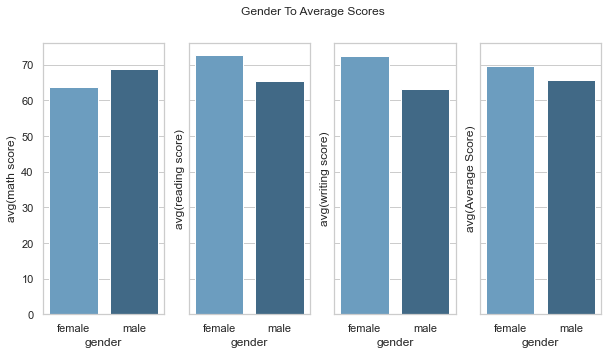

In [568]:
counter = 0
gender_scores = lunch_df.groupby("gender").avg()
gender_scores = gender_scores.toPandas()

fig, axes = plt.subplots(1, 4, figsize=(10,5), sharey=True)
fig.suptitle("Gender To Average Scores")
sns.set_theme(style="whitegrid")

for cols in gender_scores.columns[1:]:
    sns.barplot(ax=axes[counter], 
                x=gender_scores["gender"], 
                y=gender_scores[cols],
                palette="Blues_d")
    
    counter += 1

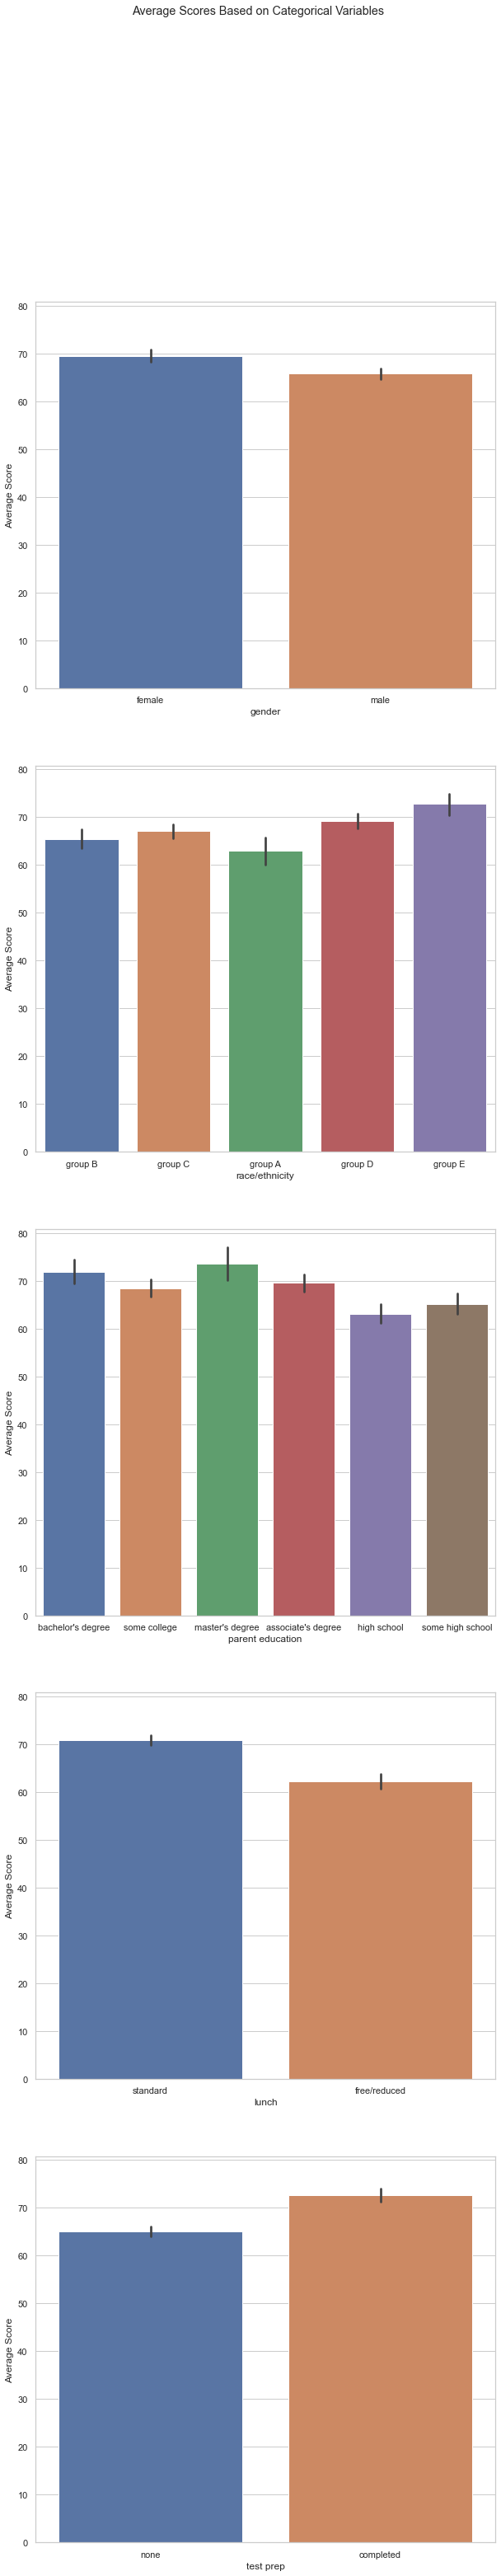

In [569]:
lunch_df = lunch_df.toPandas()
counter = 0
fig, axes = plt.subplots(5, 1, figsize=(10,50), sharey=True)
fig.suptitle("Average Scores Based on Categorical Variables")
for cols in lunch_df.columns[:-4]:
    sns.barplot(ax = axes[counter],
                x=lunch_df[cols], 
                y=lunch_df["Average Score"], 
                data = lunch_df)
    counter += 1

In [570]:
lunch_df["parent education"].unique()

array(["bachelor's degree", 'some college', "master's degree",
       "associate's degree", 'high school', 'some high school'],
      dtype=object)

In [571]:
lunch_df["parent education"] = lunch_df["parent education"].replace(
    ["bachelor's degree", 'some college', "master's degree","associate's degree", 'high school', 'some high school'], 
    ["bachelors", 'college', "masters", "associates", 'high school', 'high school'])

In [572]:
label_encoder = LabelEncoder()
lunch_df["gender"] = label_encoder.fit_transform(lunch_df["gender"])

ord_encoder = OrdinalEncoder(categories = [['high school', 'college', "associates", "bachelors", "masters"]])
lunch_df["parent education"] = ord_encoder.fit_transform(lunch_df.loc[:, ["parent education"]])

ord_encoder = OrdinalEncoder(categories = [["standard", "free/reduced"]])
lunch_df["lunch"] = ord_encoder.fit_transform(lunch_df.loc[:, ["lunch"]])

ord_encoder = OrdinalEncoder(categories = [["none", "completed"]])
lunch_df["test prep"] = ord_encoder.fit_transform(lunch_df.loc[:, ["test prep"]])


lunch_df

,gender,race/ethnicity,parent education,lunch,test prep,math score,reading score,writing score,Average Score
0,0,group B,3.0,0.0,0.0,72,72,74,72.7
1,0,group C,1.0,0.0,1.0,69,90,88,82.3
2,0,group B,4.0,0.0,0.0,90,95,93,92.7
3,1,group A,2.0,1.0,0.0,47,57,44,49.3
4,1,group C,1.0,0.0,0.0,76,78,75,76.3
...,...,...,...,...,...,...,...,...,...
995,0,group E,4.0,0.0,1.0,88,99,95,94.0
996,1,group C,0.0,1.0,0.0,62,55,55,57.3
997,0,group C,0.0,1.0,1.0,59,71,65,65.0
998,0,group D,1.0,0.0,1.0,68,78,77,74.3


<AxesSubplot:>

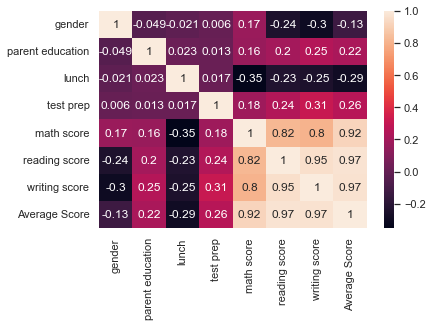

In [573]:
corr = lunch_df.corr()
sns.heatmap(corr, annot=True)

C:\Users\Julio\AppData\Local\Temp/ipykernel_22056/3795887235.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(matrix)


Text(0.5, 1.0, 'Student Performance Correlation Matrix')

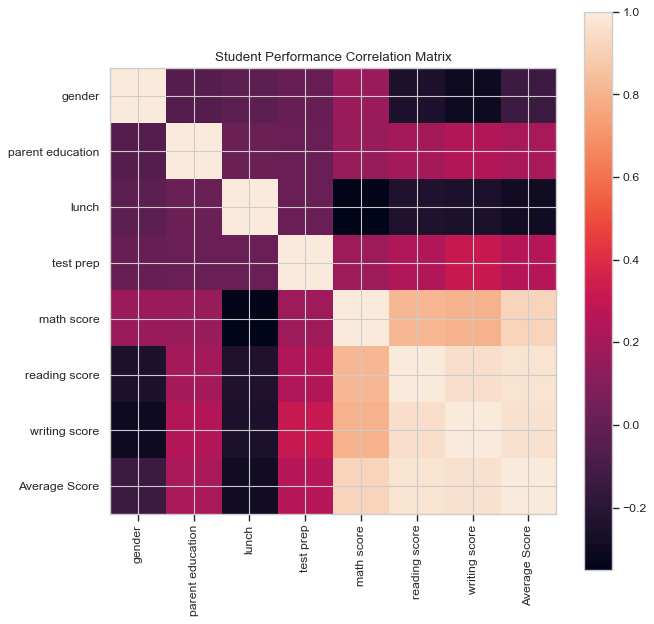

In [574]:
width = len(lunch_df.columns)
corr = lunch_df.corr()

plt.figure(num=None, figsize=(width, width), dpi=80, edgecolor="k")
matrix = plt.matshow(corr, fignum=1)

plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)

plt.gca().xaxis.tick_bottom()
plt.colorbar(matrix) 
plt.title("Student Performance Correlation Matrix")

In [575]:
lunch_df.cov()

,gender,parent education,lunch,test prep,math score,reading score,writing score,Average Score
gender,0.249926,-0.030350,-0.005115,0.001445,1.273375,-1.783241,-2.288316,-0.933177
parent education,-0.030350,1.533934,0.013714,0.007928,3.065926,3.670731,4.685646,3.807760
lunch,-0.005115,0.013714,0.229204,0.003914,-2.547142,-1.604600,-1.787958,-1.979859
test prep,0.001445,0.007928,0.003914,0.230066,1.292430,1.693191,2.280949,1.755867
math score,1.273375,3.065926,-2.547142,1.292430,229.918998,180.998958,184.939133,198.613902
reading score,-1.783241,3.670731,-1.604600,1.693191,180.998958,213.165605,211.786661,201.981285
writing score,-2.288316,4.685646,-1.787958,2.280949,184.939133,211.786661,230.907992,209.212243
Average Score,-0.933177,3.807760,-1.979859,1.755867,198.613902,201.981285,209.212243,203.267676


In [576]:
lunch_df = pd.concat([lunch_df, pd.get_dummies(lunch_df["race/ethnicity"])], axis=1)
lunch_df.drop(["race/ethnicity"], axis=1, inplace=True)


In [577]:
x = lunch_df.loc[:, ["gender", "parent education", "lunch", "test prep", "group A", "group B", "group C", "group D", "group E"]]
y = lunch_df["Average Score"]

In [584]:
x = x.values.reshape(-1, len(x.columns))
y = y.values
ols = linear_model.LinearRegression()
model = ols.fit(x, y)
print("Model Intercept: ", model.intercept_)
print("Model Coef: ", model.coef_)
print("Model Score: ", model.score(x, y))

Model Intercept:  66.87393692175534
Model Coef:  [-3.74200431  2.30620926 -8.78758896  7.66208341 -3.20684507 -1.72512715
 -0.82614419  1.97410471  3.78401169]
Model Score:  0.24000030084900859


In [585]:
x = lunch_df.loc[:, ["gender", "parent education", "lunch", "test prep", "group A", "group B", "group C", "group D", "group E"]]
y = lunch_df["Average Score"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .25)
print(len(x_train), len(x_test), len(y_train), len(y_test))

750 250 750 250


In [551]:
print("train score: ", model.score(x_train, y_train))
print("test score: ", model.score(x_test, y_test))

train score:  0.26258067397092566
test score:  0.17645651341249935


In [527]:
plt.scatter(x_test[:,0], y_test, color="black")
plt.plot(x_test, pred_reg, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

TypeError: '(slice(None, None, None), 0)' is an invalid key

In [447]:
model = GradientBoostingRegressor(random_state=0).fit(x_train, y_train)
print("train score: ", model.score(x_train, y_train))
print("test score: ", model.score(x_test, y_test))

train score:  0.31720613372578876
test score:  0.11737815409983532


In [ ]:
#cross_val_score(model, x, y, cv=10, scoring = "r2").mean()
#cross_val_score(model, x, y, cv=10, scoring = "neg_mean_squared_error").mean()
#model = LinearRegression().fit(x_train, y_train)
#pred_reg = model.predict(x_test)
#print(len(x_train), len(x_test))